Method of creating data file:
- Load `GroupFirstSub` field from FoF halos in z=0 group catalogue
- Load trees of N most massive galaxies directly
- Tried using sets with inclusion checking to speed it up, didn't work
- Used multiprocessing to speed it up massively
- Save properties to an big array
- Could use TNG100 and TNG300 for more mass range

In [1]:
# python 3.6.7
import numpy as np  # has to be upgraded to v1.19.5 for compatibility with loess
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
from loess.loess_2d import loess_2d # has to be the v2.0.11 for compatibility with numpy
import datetime

import illustris_python as il

print(np.version.version)

1.19.5


In [2]:
h = 0.6774
age = 13.8  # [Gyr]

# define base path for data
path = "../../sims.TNG/TNG100-1/output/"

num = 50000

In [3]:
# primary subhalo IDs
group_first_sub_ids = il.groupcat.loadHalos(path, 99, fields=["GroupFirstSub"])
group_first_sub_ids = list(group_first_sub_ids[group_first_sub_ids > -1])

print(len(group_first_sub_ids))

3430706


In [4]:
# define fields
fields = ["SubhaloMassType", "SnapNum"]


def loadTree(index):
    snapshots = np.full((100, 6), np.nan)
    isolate = True
    while isolate:
        tree = il.sublink.loadTree(path, 99, group_first_sub_ids[index], fields=fields, onlyMPB=True)
        if tree is None:
            group_first_sub_ids.pop(index)
        else:
            isolate = False
    snapshots[tree["SnapNum"]] = tree["SubhaloMassType"]
    return snapshots


halo_history = np.array(process_map(loadTree, range(num), max_workers=100, chunksize=10))

  0%|          | 0/50000 [00:00<?, ?it/s]

Warning, empty return. Subhalo [751052] at snapNum [99] not in tree.


In [5]:
# remove "skips"
for halo in halo_history:
    for t in range(100):
        if t > 0 and halo[t,1] == 0 and halo[t-1,1] != 0 and halo[t+1,1] != 0:
            halo[t,1] = (halo[t-1,1] + halo[t+1,1]) / 2

In [6]:
# scale to correct units and save
halo_history[halo_history == 0] = 1e6 / 1e10 * h
halo_history_scaled = np.log10(halo_history * 1e10 / h)
np.savez("history_data", halo_history_scaled, Mh=halo_history_scaled[:,:,1], Ms=halo_history_scaled[:,:,4], Mg=halo_history_scaled[:,:,0])

# Central SHMR Scatter Plot

Age of the universe from Planck: https://www.aanda.org/articles/aa/pdf/2016/10/aa25830-15.pdf

In [30]:
scale_factor = np.ndarray(100)
redshift = np.ndarray(100)

for snapshot in range(100):
    snap = il.groupcat.loadHeader(path, snapshot)
    
    scale_factor[snapshot] = snap["Time"]  # a
    redshift[snapshot] = snap["Redshift"]  # z
    
np.savez("cosmology_data", a=scale_factor, z=redshift)

In [31]:
# load data
with np.load("history_data.npz") as data:
    halo_mass = data["Mh"]
    stellar_mass = data["Ms"]
    gas_mass = data["Mg"]
    
baryonic_mass = np.log10(10**stellar_mass + 10**gas_mass)

# calculate formation time for all galaxies (time to accrete half final DM mass)
form_time = np.ndarray(len(halo_mass))
half_mass = halo_mass[:,-1] - np.log10(2)

for i in range(len(half_mass)):
    j = 0
    while halo_mass[i,j] < half_mass[i] or np.isnan(halo_mass[i,j]):
        j += 1
    form_time[i] = redshift[j]
    
print(np.min(form_time), np.max(form_time))
# form_time = np.clip(form_time, 0, 8)

2.220446049250313e-16 8.449476294368743


Smoothing out the noise in the scatter using `loess`, should take about 5 mins.

In [40]:
start = datetime.datetime.now()
smoothed_form_time, _ = loess_2d(halo_mass[:,-1], stellar_mass[:,-1], form_time, npoints=100)
end = datetime.datetime.now()

print(end - start)
smoothed_form_time = np.clip(smoothed_form_time, 0, None)
np.savez("smoothed_form_time", form_time=smoothed_form_time)

0:03:33.021875


In [41]:
with np.load("smoothed_form_time.npz") as data:
    smoothed_form_time = data["form_time"]

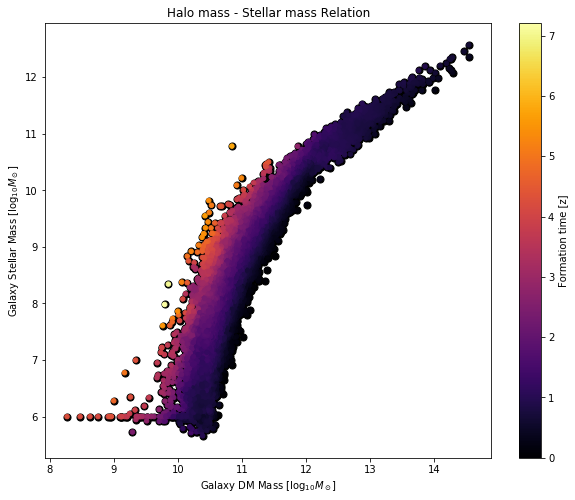

In [48]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], stellar_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], stellar_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Stellar mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Stellar Mass [$\log_{10}M_\odot$]")

# typical mass limits
# plt.ylim(8, 12) # stellar mass
# plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")

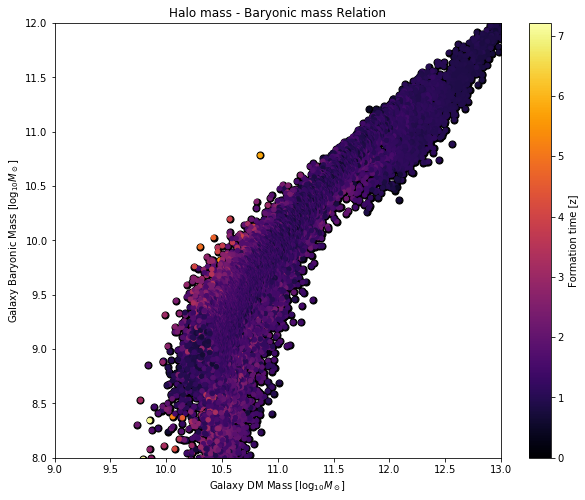

In [49]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], baryonic_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], baryonic_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Baryonic mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Baryonic Mass [$\log_{10}M_\odot$]")

# typical mass limits
plt.ylim(8, 12) # stellar mass
plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")

# fig.savefig("bhmr")

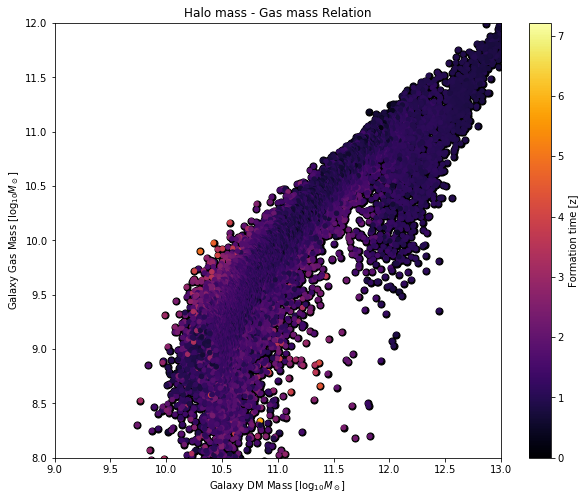

In [50]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], gas_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], gas_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Gas mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Gas Mass [$\log_{10}M_\odot$]")

# typical mass limits
plt.ylim(8, 12) # stellar mass
plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")

In [6]:
def loadbhmdot(index):
    history = np.full(100, np.nan)
    while True:
        tree = il.sublink.loadTree(path, 99, group_first_sub_ids[index], fields=["SubhaloBHMdot", "SnapNum"], onlyMPB=True)
        if tree is None:
            group_first_sub_ids.pop(index)
        else:
            break
    history[tree["SnapNum"]] = tree["SubhaloBHMdot"]
    return history


bh_mdot = np.array(process_map(loadbhmdot, range(num), max_workers=100, chunksize=10))

  0%|          | 0/50000 [00:00<?, ?it/s]

Warning, empty return. Subhalo [751052] at snapNum [99] not in tree.


In [4]:
# cache subhalos from every snapshot to select flags and group number
def cacheSnapshots(snapshot):
    return il.groupcat.loadSubhalos(path, snapshot, fields=["SubhaloFlag", "SubhaloGrNr"])

        
def loadSatellites(index):
    history = np.full(100, np.nan)
    while True:
        tree = il.sublink.loadTree(path, 99, group_first_sub_ids[index], fields=["SubhaloGrNr", "SnapNum"], onlyMPB=True)
        if tree is None:
            group_first_sub_ids.pop(index)
        else:
            break
    for snapshot, group_id in zip(tree["SnapNum"], tree["SubhaloGrNr"]):
        subs = subhalos[snapshot]
        history[snapshot] = np.count_nonzero((subs["SubhaloFlag"] == True) * (subs["SubhaloGrNr"] == group_id))
    return history


subhalos = np.array(process_map(cacheSnapshots, range(100)))
satellites = np.array(process_map(loadSatellites, range(num), max_workers=100, chunksize=10))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Warning, empty return. Subhalo [751052] at snapNum [99] not in tree.


In [7]:
# scale to correct units and save
bh_mdot_scaled = bh_mdot * 1e10 / 0.978  # [M_sol/Gyr]
np.savez("additional_data", BHMdot=bh_mdot_scaled, satellites=satellites)

SubhaloVel = peculiar velocity of the subhalo
GroupVel = velocity of group (/a to get peculiar velocity)